# COBRA MODEL

## Import Libraries

In [101]:
import math
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Dense, Layer, Dropout, LSTM
from sklearn.base import BaseEstimator
from tensorflow.keras.layers import LayerNormalization, Conv1D
import time
from random import shuffle
from sklearn.model_selection import GridSearchCV

from modelhigh import HighwayBlock

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [102]:
df_raw = pd.read_csv("Bitcoin_data.csv")
df_raw = df_raw.drop(columns=['SNo','Name','Symbol'])
df_orig = pd.read_csv("Bitcoin_data.csv")

df_raw['Date'] = pd.to_datetime(df_raw['Date']).dt.date
df_orig['Date'] = pd.to_datetime(df_orig['Date']).dt.date

print(df_raw.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Marketcap  
0  8.955395e+09  
1  8.869919e+09  
2  9.082104e+09  
3  9.217168e+09  
4  9.191325e+09  


## Feature Engineering

In [103]:
def getratio(data):
  ratios = []
  ratios.append(1)
  # data +=1e-20
  for i in range(1,len(data)):
    if data[i] ==0 or data[i-1] ==0:
      ratios.append(np.nan)
    else:
      ratios.append(data[i]/data[i-1])
  return ratios

In [104]:
def takeratio(df, col1, col2):
  temp = []
  for i in range(len(df)):
    temp.append(df.loc[i,col1]/df.loc[i,col2])
  return temp

In [105]:
def preprocess(dataf):
  df1 = dataf.copy()
  #Get the the total number of shares in the market using market cap and closing price 
  num_shares = list()
  for i in range(len(df1)):
    num_shares.append(df1.loc[i,'Marketcap']/df1.loc[i,'Close'])
  df1['Numshares'] = num_shares
  df1 = df1.drop(columns=['Marketcap'])

    

  #Create features

  # 1. ratio of x_[i] and x_[i-1] for each numeric column
  for col in df1.columns:
    if col == 'Date':
      continue
    df1[col+"_ratio"] = getratio(df1[col])
  # 2. ratio of High Low and Close Open
  df1["HighLowRatio"] = takeratio(df1,"High","Low")
  df1["CloseOpenRatio"] = takeratio(df1,"Close","Open")
  return df1

In [106]:
df = preprocess(df_raw)
print(df.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Numshares  High_ratio  Low_ratio  Open_ratio  Close_ratio  Volume_ratio  \
0  1.218305e+07    1.000000   1.000000    1.000000     1.000000      1.000000   
1  1.218680e+07    0.960837   0.988439    0.966854     0.990151      0.693639   
2  1.218993e+07    1.002075   1.012887    0.986544     1.023659      0.584859   
3  1.218992e+07    1.024031   1.036112    1.018268     1.014872      1.089231   
4  1.218992e+07    0.992147   0.997204    1.025588     0.997196      1.009156   

   Numshares_ratio  HighLowRatio  CloseOpenRatio  

## Changing closing_ratios and volume_ratios into cummulative form to get better results

In [107]:
df = df.assign(Close_ratio_cum = df['Close_ratio'])
col = df.pop('Close_ratio_cum')
df.insert(10, 'Close_ratio_cum', col)
df['Close_ratio_cum'] = df['Close_ratio_cum'].cumsum()

df = df.drop('Close_ratio', axis=1)

df = df.assign(Volume_ratio_cum = df['Volume_ratio'])
col = df.pop('Volume_ratio_cum')
df.insert(11, 'Volume_ratio_cum', col)
df['Volume_ratio_cum'] = df['Volume_ratio_cum'].cumsum()

df = df.drop('Volume_ratio', axis=1)

print(df.head())

         Date        High         Low        Open       Close      Volume  \
0  2013-12-27  777.510010  713.599976  763.280029  735.070007  46862700.0   
1  2013-12-28  747.059998  705.349976  737.979980  727.830017  32505800.0   
2  2013-12-29  748.609985  714.440002  728.049988  745.049988  19011300.0   
3  2013-12-30  766.599976  740.239990  741.349976  756.130005  20707700.0   
4  2013-12-31  760.580017  738.169983  760.320007  754.010010  20897300.0   

      Numshares  High_ratio  Low_ratio  Open_ratio  Close_ratio_cum  \
0  1.218305e+07    1.000000   1.000000    1.000000         1.000000   
1  1.218680e+07    0.960837   0.988439    0.966854         1.990151   
2  1.218993e+07    1.002075   1.012887    0.986544         3.013810   
3  1.218992e+07    1.024031   1.036112    1.018268         4.028681   
4  1.218992e+07    0.992147   0.997204    1.025588         5.025878   

   Volume_ratio_cum  Numshares_ratio  HighLowRatio  CloseOpenRatio  
0          1.000000         1.000000     

## Train Test Validation Splitting

In [108]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

temp = df_train.drop(columns=['Date']).copy()
imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputer.fit(temp)

KNNImputer(n_neighbors=3)

In [109]:
def fillnans(imputer, data):
  temp = data.drop(columns=['Date']).copy()
  data.loc[:,data.columns[1:]] = imputer.transform(temp)
  data = data.set_index('Date')
  return data

In [110]:
df_train = fillnans(imputer, df_train)
df_train = df_train.tail(-1)
df_val = fillnans(imputer, df_val)
df_test = fillnans(imputer, df_test)

In [111]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2199, 14)
Validation data shape: (275, 14)
Test data shape: (274, 14)


## Final Training Data

In [112]:
df_train.head()

,High,Low,Open,Close,Volume,Numshares,High_ratio,Low_ratio,Open_ratio,Close_ratio_cum,Volume_ratio_cum,Numshares_ratio,HighLowRatio,CloseOpenRatio
Date,,,,,,,,,,,,,,
2013-12-28,747.059998,705.349976,737.979980,727.830017,32505800.0,1.218680e+07,0.960837,0.988439,0.966854,1.990151,1.693639,1.000308,1.059134,0.986246
2013-12-29,748.609985,714.440002,728.049988,745.049988,19011300.0,1.218993e+07,1.002075,1.012887,0.986544,3.013810,2.278498,1.000256,1.047828,1.023350
2013-12-30,766.599976,740.239990,741.349976,756.130005,20707700.0,1.218992e+07,1.024031,1.036112,1.018268,4.028681,3.367729,1.000000,1.035610,1.019937
2013-12-31,760.580017,738.169983,760.320007,754.010010,20897300.0,1.218992e+07,0.992147,0.997204,1.025588,5.025878,4.376885,1.000000,1.030359,0.991701
2014-01-01,775.349976,754.969971,754.969971,771.400024,22489400.0,1.218992e+07,1.019419,1.022759,0.992963,6.048941,5.453072,1.000000,1.026994,1.021763


## Data Seperation Plots

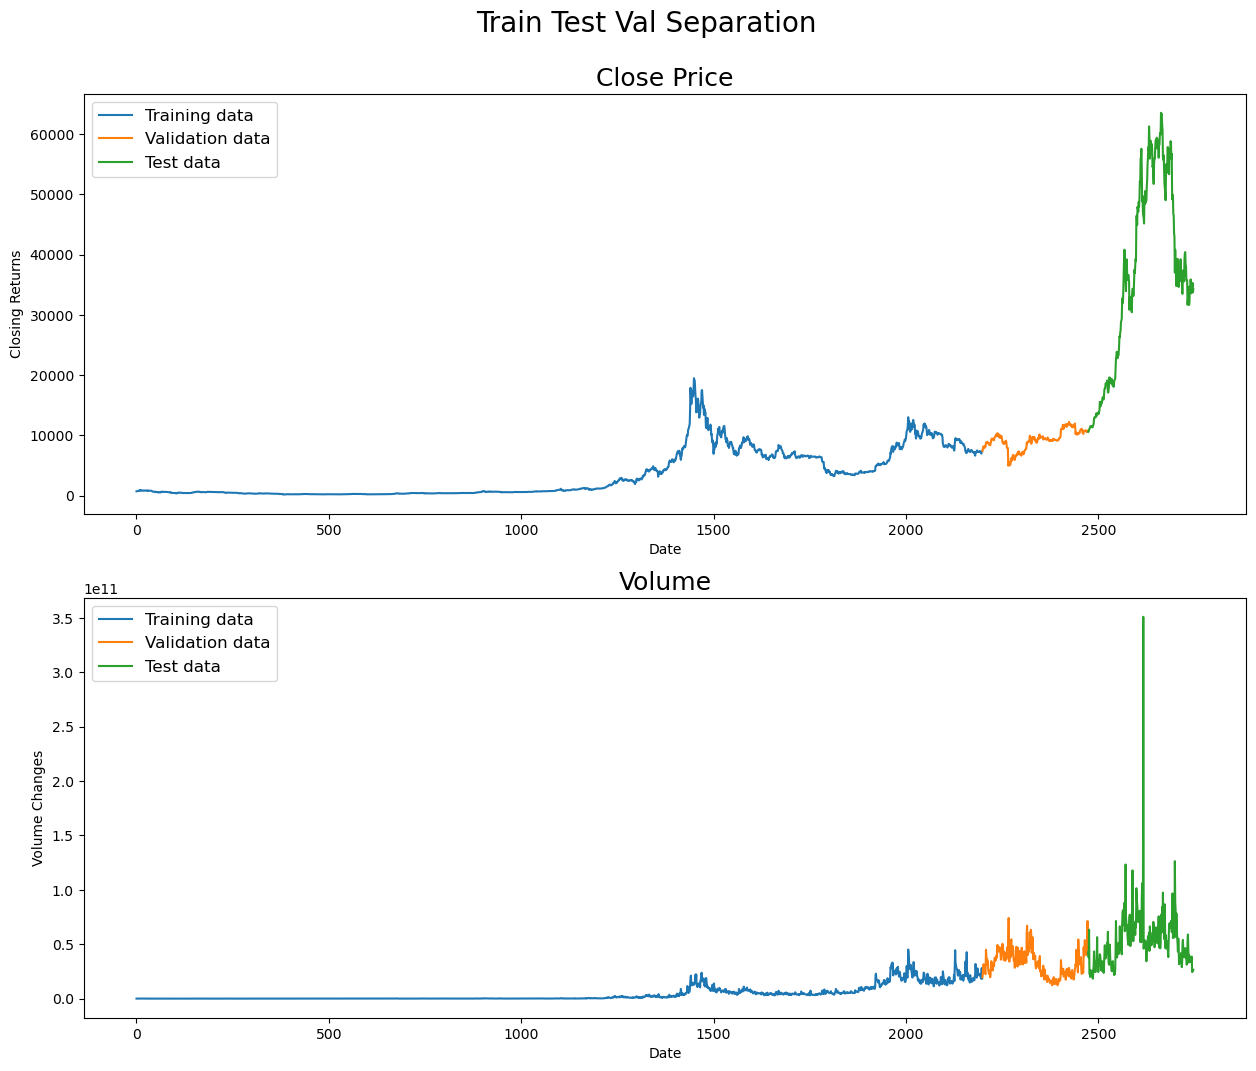

In [113]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Train Test Val Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), train_data[:, 3], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 3], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 3], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), train_data[:, 4], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), val_data[:, 4], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_data[:, 4], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

plt.savefig("6_Data_Seperation.png", dpi = 80)

plt.show()

###############################################################################


## Modification of data to load it into the model

In [114]:
look_back=20

xtrain = np.reshape(np.array(train_data[:,9:11]), (train_data.shape[0], 2))
xval = np.reshape(np.array(val_data[:, 9:11]), (val_data.shape[0], 2))
xtest = np.reshape(np.array(test_data[:, 9:11]), (test_data.shape[0], 2))


dim = xtrain.shape[1]
print(dim)

2


In [115]:
# For Multivaiate set up
def create_dataset_for_lstm(dataset, look_back=20):
    dataX, dataY, scalers = [], [], []
    dataset = np.array(dataset)
    for i in range(dataset.shape[0]-look_back-1):
        a = dataset[i:(i+look_back)]
        scaler = MinMaxScaler(feature_range=(0,1))
        b = scaler.fit_transform(a)
        dataX.append(b)
        y = scaler.transform([dataset[i + look_back]])
        y = np.reshape(y, (y.shape[1]))
        dataY.append(y)
        scalers.append(scaler)
    return np.array(dataX), np.array(dataY), np.array(scalers)

In [116]:
# Let's call this as ToplayerVersion 1 : forward pass in highway


X_train, y_train, scalers_train = create_dataset_for_lstm(xtrain, look_back)
X_val, y_val, scalers_val = create_dataset_for_lstm(xval, look_back)
X_test, y_test, scalers_test = create_dataset_for_lstm(xtest, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_train.shape[2]))

print(X_train.shape[0], X_train.shape[1], X_train.shape[2])
print(y_train.shape[0], y_train.shape[1])

2178 20 2
2178 2


## Defining classes for Transformer

In [117]:
batch_size = 32
seq_len = 20

d_k = 64
d_v = 64
n_heads = 4
ff_dim = 64

class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [118]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

In [119]:
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [120]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

## Highway Block

In [121]:
class HighwayBlock(Layer):
    def __init__(self, units, t_bias, acti_h, acti_t, **kwargs):
        super(HighwayBlock, self).__init__()
        self.units = units
        self.t_bias=t_bias
        self.acti_t= tf.nn.relu
        self.acti_h= tf.nn.sigmoid

    def build(self, input_shape):
        self.W = self.add_weight(
#           name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.W_T = self.add_weight(
#           name="w_T",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        
        self.b = self.add_weight(
#           name="b", 
            shape=(self.units,), initializer="random_normal", trainable=True,
        )

        self.b_T = tf.Variable(tf.constant(self.t_bias, shape=self.units), name="bias", trainable=True)
        # assert self.b_T.shape == (50,), 'b.shape: {}'.format(self.b.shape)

    def call(self, inputs):
        h = self.acti_h(tf.matmul(inputs, self.W) + self.b)
        t = self.acti_t(tf.matmul(inputs, self.W_T) + self.b_T)
        y = tf.add(tf.multiply(h, t) , tf.multiply(inputs, (1- t)))
        return y
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({'units': self.units,
                       't_bias': self.t_bias,
                       'acti_t': self.acti_t,
                       'acti_h': self.acti_h}) 
        return config

## Fetching all models together

In [122]:
lstm = tf.keras.models.load_model('cum_lstm_baseline.hdf5')

gru = tf.keras.models.load_model('gru_baseline.hdf5')

hybrid = tf.keras.models.load_model('hybrid_baseline.hdf5')
											 
highwaylstm = tf.keras.models.load_model('highwaylstm_baseline.hdf5', custom_objects={'LSTM': LSTM, 
											 'HighwayBlock': HighwayBlock, 
											 'Dense' : Dense})

transformer = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

#############################################################################

all_models ={
    'lstm':lstm,
    'gru':gru,
    'hybrid_lstm_gru': hybrid,
    'highwaylstm': highwaylstm,
    'transformer': transformer
}

## COBRA Implementation

In [123]:
class MyCobra(BaseEstimator):
    def __init__(self, random_state=42, epsilon=None, models={}, frac=0.8):
        self.random_state = random_state
        self.epsilon = epsilon
        self.estimators_ = models
        self.models = models
        if len(models) == 0:
            raise "Please provide the models to be used"
        self.frac = frac

    def prep_data(self, k=None, l=None, shuffle_data=False):

        if shuffle_data:
            self.X_, self.y_ = shuffle(
                self.X_, self.y_, random_state=self.random_state)

        if k is None and l is None:
            k = int(len(self.X_) * self.frac)
            l = int(len(self.X_))

        if k is not None and l is None:
            l = len(self.X_) - k

        if l is not None and k is None:
            k = len(self.X_) - l

        self.X_k_ = self.X_[:k]
        self.X_l_ = self.X_[k:l]
        self.y_k_ = self.y_[:k]
        self.y_l_ = self.y_[k:l]

        return self

    def pred(self, X, alpha, info=False):

        select = {}
        vals = []
        for name, model in self.estimators_.items():
            val = model.predict(X)
            vals.append(val)
            select[model] = set()
#             print("yoyo")
#             print(val)
#             print(name,self.model_preds_[name][0])

            # self.tempcal = np.array([])

            for count in range(0, len(self.X_l_)):
                # if its in epsilon distance get idx
                # print(np.sqrt(np.mean(np.fabs(self.model_preds_[name][count] - val)**2)))

                if np.sqrt(np.mean(np.fabs(self.model_preds_[name][count] - val)**2)) <= self.epsilon:
                    select[model].add(count)
                # tempcal = np.append(tempcal, np.sqrt(np.mean(np.fabs(self.model_preds_[name][count] - val)**2)))

        points = []
        # count is the indice number.
        for count in range(0, len(self.X_l_)):
            # row check is number of machines which picked up a particular point
            row_check = 0

            for machine in select:
                if count in select[machine]:
                    row_check += 1
            if row_check >= alpha:
                points.append(count)

        # print(np.mean(np.mean(vals, axis=1), axis=0).shape)
        # if no points are selected, return 0
        # print("Check points", len(points))
        if len(points) == 0:
        	return np.mean(vals, axis=0)

        # take mean
        print("Print y_l_", self.y_l_.shape)

        avg = np.zeros(2).reshape(1, 2)
        for point in points:
            avg += self.y_l_[point][:].reshape(1, 2)

        avg /= len(points)

        return np.array(avg)

    def predict(self, X, alpha=None, info=False):

        if alpha is None:
            alpha = len(self.estimators_)

#        if len(X) == 1:
#            ans = self.pred(X.reshape(1, X.shape[1], X.shape[2]), alpha=alpha)
#            ans = np.array(ans)
#        else:
        ans = []
        for i in range(len(X)):
            ans.append(self.pred(X[i].reshape(
                1, X.shape[1], X.shape[2]), alpha=alpha))
            # print("Print Koro", ans)

        return ans

    def get_models_predictions(self):
        self.model_preds_ = {}
        self.all_preds_ = np.array([])

        for model in self.estimators_:
            self.model_preds_[model] = self.estimators_[model].predict(self.X_l_)[
                :, -1]
            # print(self.model_preds_[model])
            self.all_preds_ = np.append(
                self.all_preds_, np.array(self.model_preds_[model]))
        return self

    def fit(self, X, y, default=True, X_k=None, X_l=None, y_k=None, y_l=None):
        self.X_ = X
        self.y_ = y
        self.X_k_ = X_k
        self.X_l_ = X_l
        self.y_k_ = y_k
        self.y_l_ = y_l

        # set up data
        self.prep_data()
        self.get_models_predictions()

        return self

    def set_epsilon(self, X_eps, y_eps, grid_points=50):
        self.X_ = X_eps
        self.y_ = y_eps
        self.prep_data()
        self.get_models_predictions()
        temp = sorted(self.all_preds_)
        res = [temp[i + 1] - temp[i] for i in range(len(temp)-1)]
        emin = np.min(res)
        emax = np.max(res) - np.min(res)
        erange = np.linspace(emin, emax, grid_points)
        tuned_parameters = [{'epsilon': erange}]
        clf = GridSearchCV(self, tuned_parameters,
                           scoring="neg_mean_squared_error")
        clf.fit(X_eps, y_eps, default=False)
        self.epsilon = clf.best_params_["epsilon"]
        self.estimators_, self.model_preds_ = {}, {}
        
        
    def Extracount(self, X, info=False):
       
        select = {}
        vals = []
        tempcal = np.array([])
        
        for name, model in self.estimators_.items():
            val = model.predict(X)
            vals.append(val)
            select[model] = set()
            
#             print("yoyo")
#             print(val)
#             print(name,self.model_preds_[name][0])

#            self.tempcal = np.array([])
            
            for count in range(0, len(self.X_l_)):
                 tempcal = np.append(tempcal, np.sqrt(np.mean(np.fabs(self.model_preds_[name][count] - val)**2)))
                    # if its in epsilon distance get idx
#                     print(np.abs(self.model_preds_[name][count] - val))
                    #if np.sqrt(np.mean(np.fabs(self.model_preds_[name][count] - val)**2)) <= self.epsilon:
                     #   select[model].add(count)

                                                        
        return tempcal


## Ensembling all the models

In [124]:
ensemble = MyCobra(models = all_models, epsilon=0.005)

In [125]:
ensemble

MyCobra(epsilon=0.005,
        models={'gru': <keras.engine.sequential.Sequential object at 0x7fb71550afe0>,
                'highwaylstm': <keras.engine.sequential.Sequential object at 0x7fb734cebd00>,
                'hybrid_lstm_gru': <keras.engine.sequential.Sequential object at 0x7fb71550a650>,
                'lstm': <keras.engine.sequential.Sequential object at 0x7fb7355b8fd0>,
                'transformer': <keras.engine.functional.Functional object at 0x7fb73317c670>})

In [126]:
ensemble.fit(X_train, y_train)

14/14 [==============================] - 2s 8ms/step


MyCobra(epsilon=0.005,
        models={'gru': <keras.engine.sequential.Sequential object at 0x7fb71550afe0>,
                'highwaylstm': <keras.engine.sequential.Sequential object at 0x7fb734cebd00>,
                'hybrid_lstm_gru': <keras.engine.sequential.Sequential object at 0x7fb71550a650>,
                'lstm': <keras.engine.sequential.Sequential object at 0x7fb7355b8fd0>,
                'transformer': <keras.engine.functional.Functional object at 0x7fb73317c670>})

In [127]:
val_pred = ensemble.predict(X_val,1)

1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

In [128]:
test_pred = ensemble.predict(X_test,1)

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

In [129]:
train_pred = ensemble.predict(X_train,1)

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 32ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 29ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 28ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 28ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 33ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 39ms/step
Print y_l_ (

1/1 [==============================] - 0s 32ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 35ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 29ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 34ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 37ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 33ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 45ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 28ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 29ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 30ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 28ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 29ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 28ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 31ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 27ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (

1/1 [==============================] - 0s 24ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 25ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 26ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 24ms/step
Print y_l_ (

1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 22ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (436, 2)
1/1 [==============================] - 0s 23ms/step
Print y_l_ (

In [130]:
train_pred = np.array(train_pred)
val_pred = np.array(val_pred)
test_pred = np.array(test_pred)

In [131]:
print(train_pred.shape)
print(val_pred.shape)
print(test_pred.shape)

(2178, 1, 2)
(254, 1, 2)
(253, 1, 2)


In [132]:
train_pred = np.squeeze(train_pred)
val_pred = np.squeeze(val_pred)
test_pred = np.squeeze(test_pred)

In [133]:
print(train_pred.shape)
print(val_pred.shape)
print(test_pred.shape)

(2178, 2)
(254, 2)
(253, 2)


# Evaluation metrics

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def result(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')
    mape = mean_absolute_percentage_error(y_pred=y_pred, y_true=y_true, multioutput='raw_values')
    mse_str = ', '.join(['{:.6f}'.format(val) for val in mse])
    mae_str = ', '.join(['{:.6f}'.format(val) for val in mae])
    mape_str = ', '.join(['{:.6f}'.format(val) for val in mape])
    print(name+' Data - Loss: [{}], MAE: [{}], MAPE: [{}]'.format(mse_str, mae_str, mape_str))

# Print evaluation metrics for all datasets
print('Evaluation metrics')
result("Training", y_train, train_pred)
result("Validation", y_val, val_pred)
result("Testing", y_test, test_pred)

Evaluation metrics
Training Data - Loss: [0.000004, 0.000638], MAE: [0.001347, 0.014739], MAPE: [0.001279, 0.013741]
Validation Data - Loss: [0.000005, 0.000125], MAE: [0.001247, 0.008182], MAPE: [0.001186, 0.007735]
Testing Data - Loss: [0.000006, 0.000472], MAE: [0.001811, 0.010759], MAPE: [0.001720, 0.009997]


## Applying inverse transformation

In [135]:
for i in range(np.array(train_pred).shape[0]):
  train_pred[i] = scalers_train[i].inverse_transform([train_pred[i]])
  #print(trainPredict[i])
  y_train[i] = scalers_train[i].inverse_transform([y_train[i]])

for i in range(np.array(val_pred).shape[0]):
  val_pred[i] = scalers_val[i].inverse_transform([val_pred[i]])
  #print(trainPredict[i])
  y_val[i] = scalers_val[i].inverse_transform([y_val[i]])

for i in range(np.array(test_pred).shape[0]):
   test_pred[i] = scalers_test[i].inverse_transform([test_pred[i]])
   y_test[i] = scalers_test[i].inverse_transform([y_test[i]])
    

#############################################################################

## Making the Closing ratio and Volume ratio in their orginal forms

In [136]:
# convert cumulative data to normal data
def convert_cumulative_to_original_column_wise(cumulative_array):
    n_rows, n_cols = cumulative_array.shape
    original_array = np.zeros((n_rows, n_cols), dtype=cumulative_array.dtype)

    for i in range(n_cols):
        original_array[0, i] = cumulative_array[0, i]

        for j in range(1, n_rows):
            original_array[j, i] = cumulative_array[j, i] - cumulative_array[j-1, i]

    return original_array

In [137]:
train_pred = convert_cumulative_to_original_column_wise(train_pred)
test_pred = convert_cumulative_to_original_column_wise(test_pred)
val_pred = convert_cumulative_to_original_column_wise(val_pred)

xtrain = convert_cumulative_to_original_column_wise(xtrain)
xval = convert_cumulative_to_original_column_wise(xval)
xtest = convert_cumulative_to_original_column_wise(xtest)

## Plotting the results

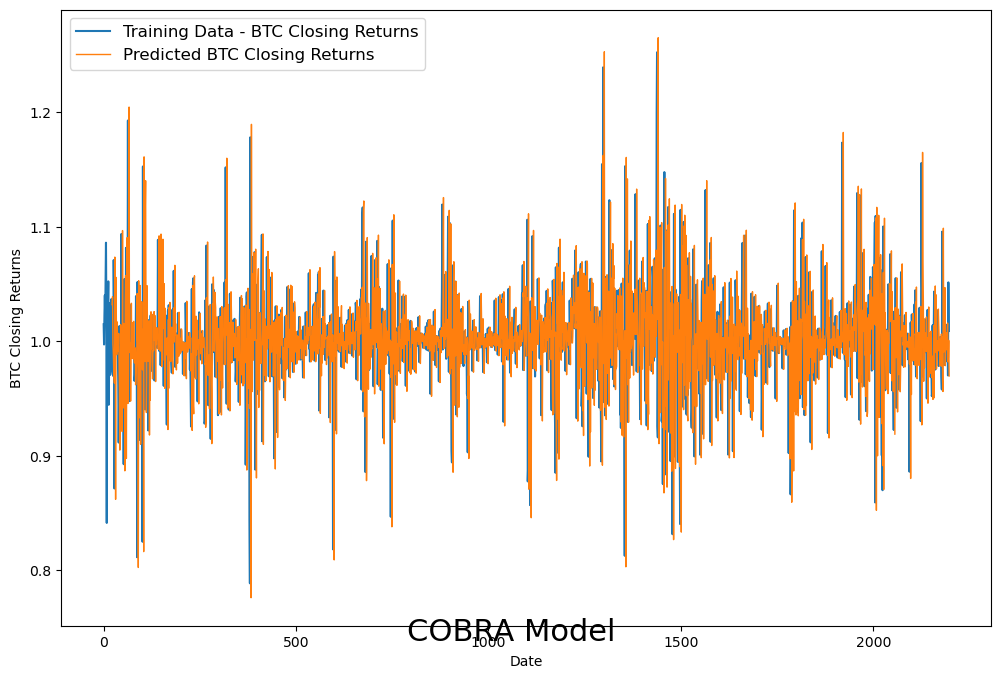

In [138]:
fig = plt.figure(figsize=(12, 8))
st = fig.suptitle("COBRA Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[2:, 0], label='Training Data - BTC Closing Returns')
ax11.plot(np.arange(look_back+2, train_pred.shape[0]+look_back), train_pred[2:,0], linewidth=1, label='Predicted BTC Closing Returns')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

plt.savefig("6_Predicted_Vs_Original_Training_Closing_return_Data.png", dpi = 80)


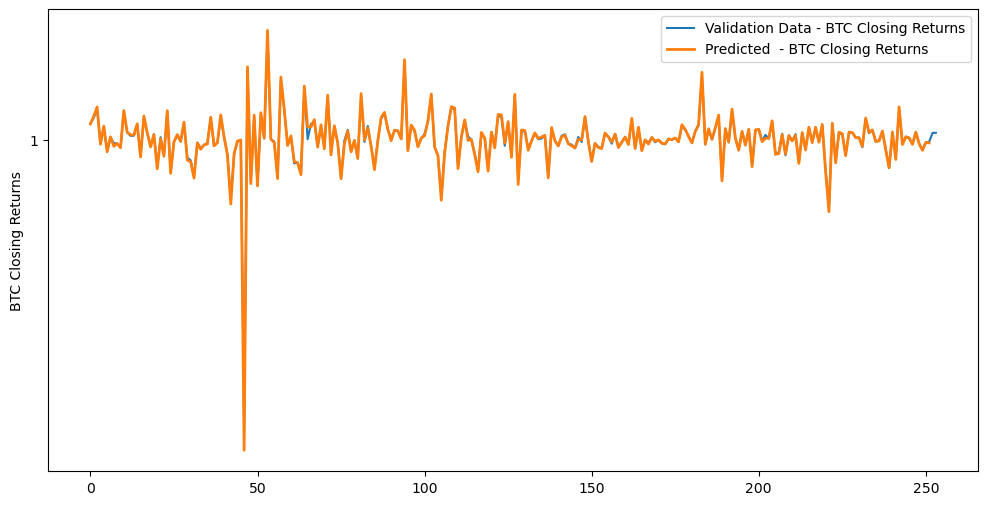

In [139]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,0]), label='Validation Data - BTC Closing Returns')
plt.plot(np.log(val_pred[2:,0]), linewidth=2, label='Predicted  - BTC Closing Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("6_Predicted_Vs_Original_Validation_Closing_Returns_Data.png", dpi = 80)

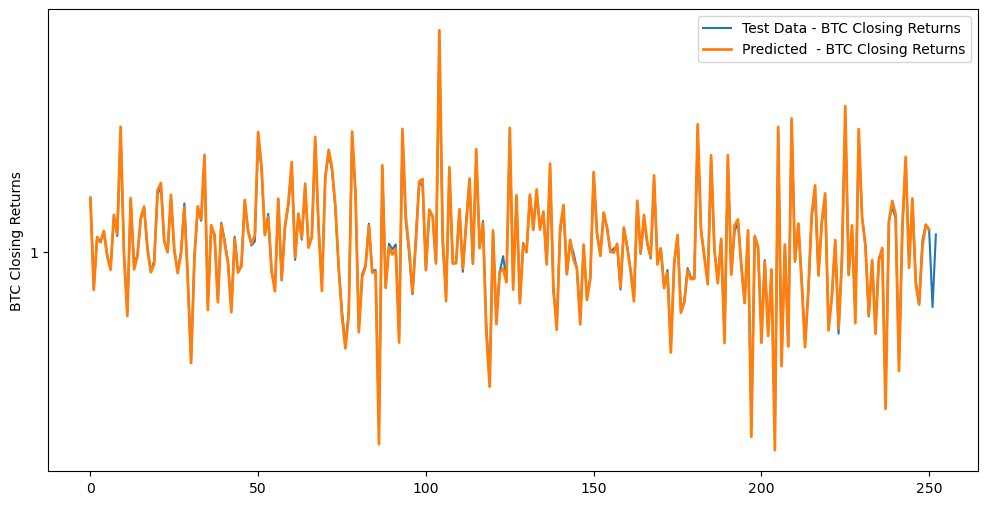

In [140]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,0]), label='Test Data - BTC Closing Returns')
plt.plot(np.log(test_pred[2:,0]), linewidth=2, label='Predicted  - BTC Closing Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Closing Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("6_Predicted_Vs_Original_Test_Closing_Returns_Data.png", dpi = 80)

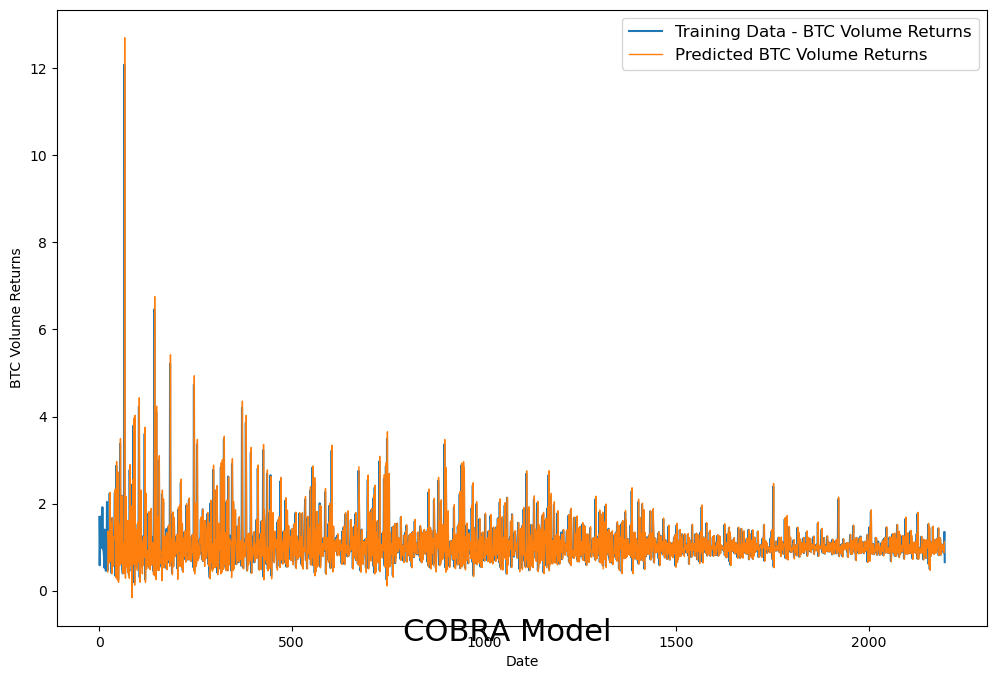

In [141]:
fig = plt.figure(figsize=(12, 8))
st = fig.suptitle("COBRA Model", fontsize=22)
st.set_y(0.12)

#Plot training data results
ax11 = fig.add_subplot(111)
ax11.plot(xtrain[:, 1], label='Training Data - BTC Volume Returns')
ax11.plot(np.arange(look_back+2, train_pred.shape[0]+look_back), train_pred[2:,1], linewidth=1, label='Predicted BTC Volume Returns')
ax11.set_title("", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Volume Returns')
ax11.legend(loc="best", fontsize=12)

plt.savefig("6_Predicted_Vs_Original_Training_Volume_return_Data.png", dpi = 80)


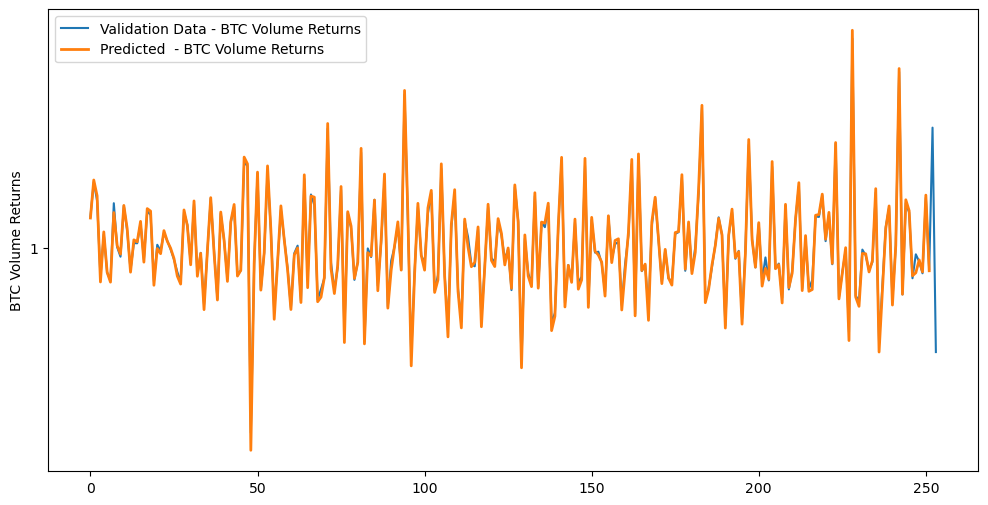

In [142]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xval[21:,1]), label='Validation Data - BTC Volume Returns')
plt.plot(np.log(val_pred[2:,1]), linewidth=2, label='Predicted  - BTC Volume Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Volume Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("6_Predicted_Vs_Original_Validation_Volume_Returns_Data.png", dpi = 80)


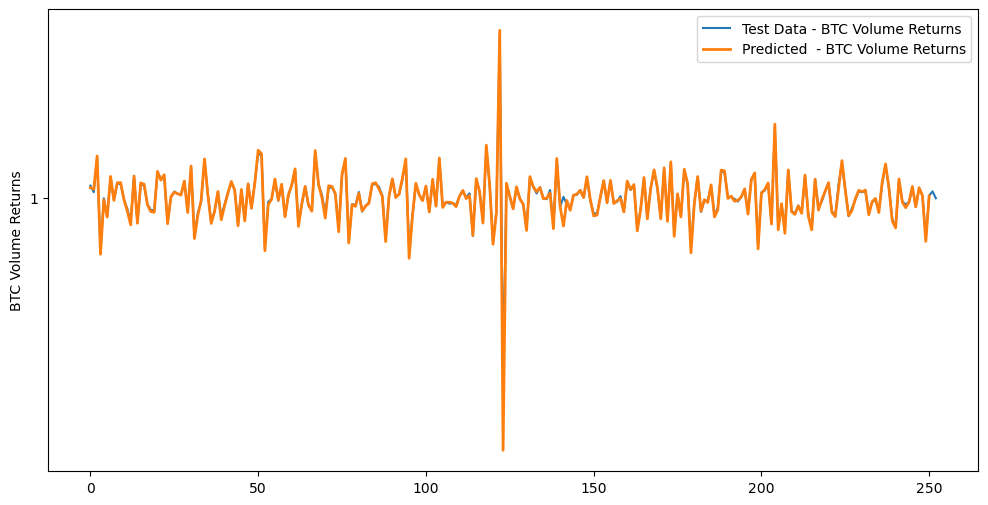

In [143]:
fig = plt.figure(figsize=(12, 6))
# create a plot

plt.plot(np.log(xtest[21:,1]), label='Test Data - BTC Volume Returns')
plt.plot(np.log(test_pred[2:,1]), linewidth=2, label='Predicted  - BTC Volume Returns')

# set the y-axis label and tick labels
plt.ylabel('BTC Volume Returns')
yticks = [10**i for i in range(0,1)]
plt.yticks(np.log(yticks), yticks)

plt.legend()

plt.savefig("6_Predicted_Vs_Original_Test_Volume_Returns_Data.png", dpi = 80)
